In [1]:
import torch
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
file_path = 'megafile.csv'  # Replace with the path to your file
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())

# Display the first few rows
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Columns: 131 entries, Player to Expected np:G-xG
dtypes: float64(124), int64(1), object(6)
memory usage: 2.8+ MB
None
            Player Nation      Squad   Age  Born  Playing Time MP  \
0  Aaron Cresswell    ENG   West Ham  33.0  1989             11.0   
1     Aaron Hickey    SCO  Brentford  21.0  2002              9.0   
2    Aaron Malouda    FRA      Lille  17.0  2005              1.0   
3   Aaron Ramsdale    ENG    Arsenal  25.0  1998              6.0   
4     Aaron Ramsey    ENG    Burnley  20.0  2003             14.0   

   Playing Time Starts  Playing Time Min  Playing Time 90s  Performance Gls  \
0                  4.0             436.0               4.8              0.0   
1                  9.0             713.0               7.9              0.0   
2                  0.0               1.0               0.0              0.0   
3                  6.0             540.0               6.0              0.0 

In [2]:
import torch.nn as nn
class GRBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(GRBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible))
        self.visible_bias = nn.Parameter(torch.randn(n_visible))
        self.hidden_bias = nn.Parameter(torch.randn(n_hidden))

    def forward(self, v):
        # Compute probabilities of hidden units given visible units (Gaussian)
        hidden_prob = torch.sigmoid(torch.matmul(v, self.W.T) + self.hidden_bias)
        # Sample hidden units (binary) using these probabilities
        hidden = torch.bernoulli(hidden_prob)
        
        # Compute mean of visible units given hidden units (Bernoulli)
        visible_mean = torch.sigmoid(torch.matmul(hidden, self.W) + self.visible_bias)
        # Sample visible units (binary) using these means
        visible_sample = torch.bernoulli(visible_mean)
        
        return visible_mean, hidden

In [3]:
# Training loop for GRBM
def train_GRBM(model, data_loader, num_epochs=10, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()  # Binary Cross Entropy loss for Bernoulli units

    for epoch in range(num_epochs):
        model.train()
        recon_loss = 0.0
        for batch in data_loader:
            batch = batch[0]  # Extract the tensor from the tuple
            optimizer.zero_grad()
            reconstructed, _ = model(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            recon_loss += loss.item() * len(batch)
        
        recon_loss /= len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Loss: {recon_loss:.4f}")

In [4]:
df = df.drop(columns = ['Age','Playing Time MP','Playing Time Starts','Playing Time Min', '90s', 'Age', 'Born', 'Nation'])

divider_column = 'Playing Time 90s'
exclude_columns = [col for col in df.columns if '%' in col or '90' in col or df[col].dtype == 'object']
# Create a mask for rows where the divisor is zero
zero_divisor_mask = df[divider_column] == 0

# Perform the division for the remaining columns
for col in df.columns:
    if col not in exclude_columns and col != divider_column:
        # Set the values to 0 where the divisor is zero
        df.loc[zero_divisor_mask, col] = 0
        # Perform the division for the remaining values
        df.loc[~zero_divisor_mask, col] = df.loc[~zero_divisor_mask, col] / df.loc[~zero_divisor_mask, divider_column]

df = df[df['Playing Time 90s'] >= 10]
df = df.drop(columns = ['Playing Time 90s'])
df = df.reset_index()

In [5]:
corr_matrix = df.corr(numeric_only = True)

# Unstack the correlation matrix and reset index
corr_pairs = corr_matrix.unstack().reset_index()

# Rename columns for clarity
corr_pairs.columns = ['Variable_1', 'Variable_2', 'Correlation']

# Remove self-correlations and duplicate pairs
corr_pairs = corr_pairs[corr_pairs['Variable_1'] != corr_pairs['Variable_2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])

# Sort by the absolute value of correlation
corr_pairs['Abs_Correlation'] = corr_pairs['Correlation'].abs()
corr_pairs = corr_pairs.sort_values(by='Abs_Correlation', ascending=False)

In [6]:
# Filter pairs with a correlation of 1 (excluding self-correlations)
perfect_corr_pairs = corr_pairs[(corr_pairs['Correlation'] >= 0.95) & (corr_pairs['Variable_1'] != corr_pairs['Variable_2'])]

# Identify variables to remove (you can choose based on your criteria)
variables_to_remove = set()
for _, row in perfect_corr_pairs.iterrows():
    var1, var2 = row['Variable_1'], row['Variable_2']
    if var1 not in variables_to_remove and var2 not in variables_to_remove:
        # Add one of the variables to the removal set
        variables_to_remove.add(var2)  # Here, we're arbitrarily choosing var2

# Remove the identified variables from the DataFrame
df = df.drop(columns=variables_to_remove)

In [7]:
# Fill null values in 'secondary_position' with values from 'primary_position'
df['Position_2'] = df['Position_2'].fillna(df['Position'])

# Handle missing values (if any)
df = df.dropna()

numeric_cols = df.select_dtypes(include=[np.number]).columns
pt = PowerTransformer(method='yeo-johnson')
df[numeric_cols] = pt.fit_transform(df[numeric_cols])

# Standardize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[numeric_cols])



In [8]:
tensor_data = torch.tensor(scaled_data, dtype=torch.float32)

batch_size = 64
dataset = TensorDataset(tensor_data)
train_loader = DataLoader(dataset, batch_size=batch_size)

# Initialize and train the GRBM model
n_visible = scaled_data.shape[1]
n_hidden = 10  # Adjust as needed
grbm = GRBM(n_visible=n_visible, n_hidden=n_hidden)
train_GRBM(grbm, train_loader)

grbm.eval()
with torch.no_grad():
    latent_features = []
    for batch in train_loader:
        batch = batch[0]  # Extract the tensor from the tuple
        _, hidden = grbm(batch)
        latent_features.append(hidden)
    latent_features = torch.cat(latent_features).numpy()




Epoch [1/10], Reconstruction Loss: 0.9568
Epoch [2/10], Reconstruction Loss: 0.7712
Epoch [3/10], Reconstruction Loss: 0.7111
Epoch [4/10], Reconstruction Loss: 0.6796
Epoch [5/10], Reconstruction Loss: 0.6554
Epoch [6/10], Reconstruction Loss: 0.6383
Epoch [7/10], Reconstruction Loss: 0.6258
Epoch [8/10], Reconstruction Loss: 0.6180
Epoch [9/10], Reconstruction Loss: 0.6135
Epoch [10/10], Reconstruction Loss: 0.6105


In [9]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=8)
clusters = dbscan.fit_predict(latent_features)
df['Cluster'] = clusters

# Calculate silhouette score
silhouette_avg = silhouette_score(latent_features, clusters)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.9465101361274719


In [10]:
def get_top_5_stats(player_stats):
    player_stats = player_stats.drop(['Player', 'Position', 'Position_2', 'cluster'], errors='ignore')
    player_stats = pd.to_numeric(player_stats, errors='coerce').dropna()
    top_5_stats = player_stats.nlargest(5)
    return top_5_stats

# Function to find closest players
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_players_cosine(df, latent_features, player_name, top_n=5):
    try:
        player_row = df[df['Player'] == player_name].iloc[0]
    except IndexError:
        raise ValueError(f"Player {player_name} not found in the dataset.")
    
    player_index = player_row.name
    player_positions = [player_row['Position'], player_row['Position_2']]
    position_filter = df['Position'].isin(player_positions) | df['Position_2'].isin(player_positions)
    filtered_df = df[position_filter]
    filtered_indices = filtered_df.index
    filtered_latent_space = latent_features[filtered_indices]
    filtered_df = filtered_df.drop(player_index)
    filtered_latent_space = np.delete(filtered_latent_space, np.where(filtered_indices == player_index)[0][0], axis=0)
    player_latent = latent_features[player_index].reshape(1, -1)
    similarities = cosine_similarity(filtered_latent_space, player_latent).flatten()
    closest_indices = np.argsort(-similarities)[:top_n]
    closest_players = filtered_df.iloc[closest_indices][['Player', 'Position', 'Position_2']]
    input_player_stats = df.loc[player_index]
    input_player_top_5_stats = get_top_5_stats(input_player_stats)
    
    print(f"\nTop 5 stats for {player_name}:")
    print(input_player_top_5_stats)
    
    comparison_df = pd.DataFrame(columns=['Player'] + list(input_player_top_5_stats.index))
    for index, row in closest_players.iterrows():
        similar_player_name = row['Player']
        similar_player_stats = df.loc[df['Player'] == similar_player_name].iloc[0]
        similar_player_top_5_stats = similar_player_stats[input_player_top_5_stats.index]
        comparison_df = pd.concat([comparison_df, pd.DataFrame([pd.Series([similar_player_name] + list(similar_player_top_5_stats.values), index=comparison_df.columns)])], ignore_index=True)
    
    return comparison_df

# Input player name and find closest matches
player_name = input("Please enter the name of the player you want to find similar to (all accents included): ")
try:
    closest_matches = find_closest_players_cosine(df, latent_features, player_name)
except ValueError as e:
    print(e)
    player_name = input("Please enter the name of the player you want to find similar to (all accents included): ")
    closest_matches = find_closest_players_cosine(df, latent_features, player_name)

print(closest_matches)


Top 5 stats for Casemiro:
Blocks                          4.928681
Challenges Attempted            3.285674
Challenges Lost                 2.798214
Challenges dribblers Tackled    2.688449
Players Tackled                 2.450103
Name: 251, dtype: float64
               Player    Blocks  Challenges Attempted  Challenges Lost  \
0       Junior Sambia  0.467856             -0.584163        -0.624967   
1        Sael Kumbedi  0.185989              0.818666         1.125031   
2      Julien Ponceau -0.373751             -0.261737         0.338769   
3      Julián Álvarez -0.103318             -0.410650         0.281960   
4  Junior Dina Ebimbe  0.439337              0.549047         0.765463   

   Challenges dribblers Tackled  Players Tackled  
0                     -0.378546        -0.559717  
1                      0.397503         1.570514  
2                     -0.781538        -0.260933  
3                     -1.023235        -0.849497  
4                      0.306770         0.

C:\Users\Shabeer\AppData\Local\Temp\ipykernel_29208\1070559640.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, pd.DataFrame([pd.Series([similar_player_name] + list(similar_player_top_5_stats.values), index=comparison_df.columns)])], ignore_index=True)


In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop('Cluster')  # Ensure 'Cluster' is not considered a factor

# Compute summary statistics for numeric columns only
cluster_stats = df.groupby('Cluster')[numeric_cols].mean()

# Function to get the 5 most significant stats for each cluster
def get_top_features(cluster_stats, n=5):
    top_features = {}
    for cluster_id, stats in cluster_stats.iterrows():
        top_stats = stats.sort_values(ascending=False).head(n).index.tolist()
        top_features[cluster_id] = top_stats
    return top_features

# Get the top 5 significant stats for each cluster
top_features = get_top_features(cluster_stats, n=5)

# Create a new DataFrame to store cluster information and significant stats
cluster_info_list = []

for cluster_id, features in top_features.items():
    cluster_info_list.append({
        'Cluster': cluster_id,
        'Top_Feature_1': features[0] if len(features) > 0 else None,
        'Top_Feature_2': features[1] if len(features) > 1 else None,
        'Top_Feature_3': features[2] if len(features) > 2 else None,
        'Top_Feature_4': features[3] if len(features) > 3 else None,
        'Top_Feature_5': features[4] if len(features) > 4 else None
    })

cluster_info = pd.DataFrame(cluster_info_list)

# Print the cluster information DataFrame
print(cluster_info)

    Cluster             Top_Feature_1             Top_Feature_2  \
0        -1  Touches Def Penalty Area          Short Completed%   
1         0             Shots Blocked                Clearances   
2         1                   Crosses       Penalty Area Passes   
3         2             Expected xG_x           Performance Gls   
4         3          Short Completed%  Touches Def Penalty Area   
5         4          Short Completed%  Touches Def Penalty Area   
6         5                Clearances             Shots Blocked   
7         6          Short Completed%  Touches Def Penalty Area   
8         7     Long Attempted Passes          Short Completed%   
9         8                Clearances           Touches Def 3rd   
10        9          Short Completed%  Touches Def Penalty Area   

               Top_Feature_3             Top_Feature_4          Top_Feature_5  
0          Medium Completed%     Long Attempted Passes      Total PrgPassDist  
1            Touches Def 3rd  Touch

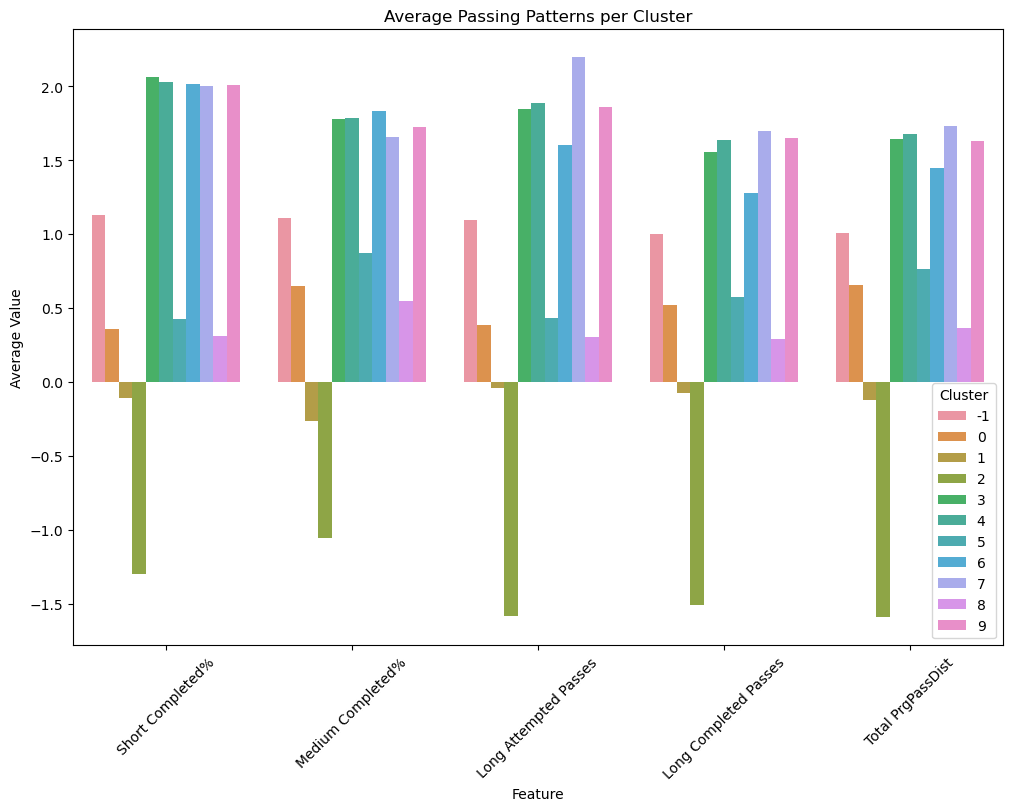

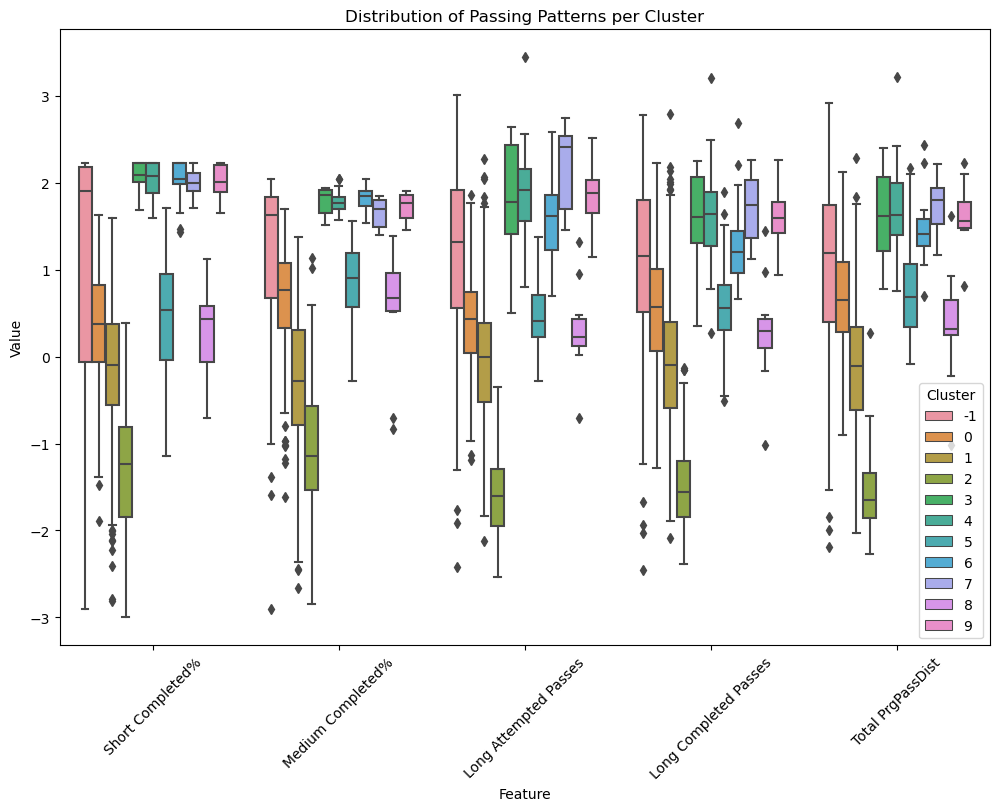

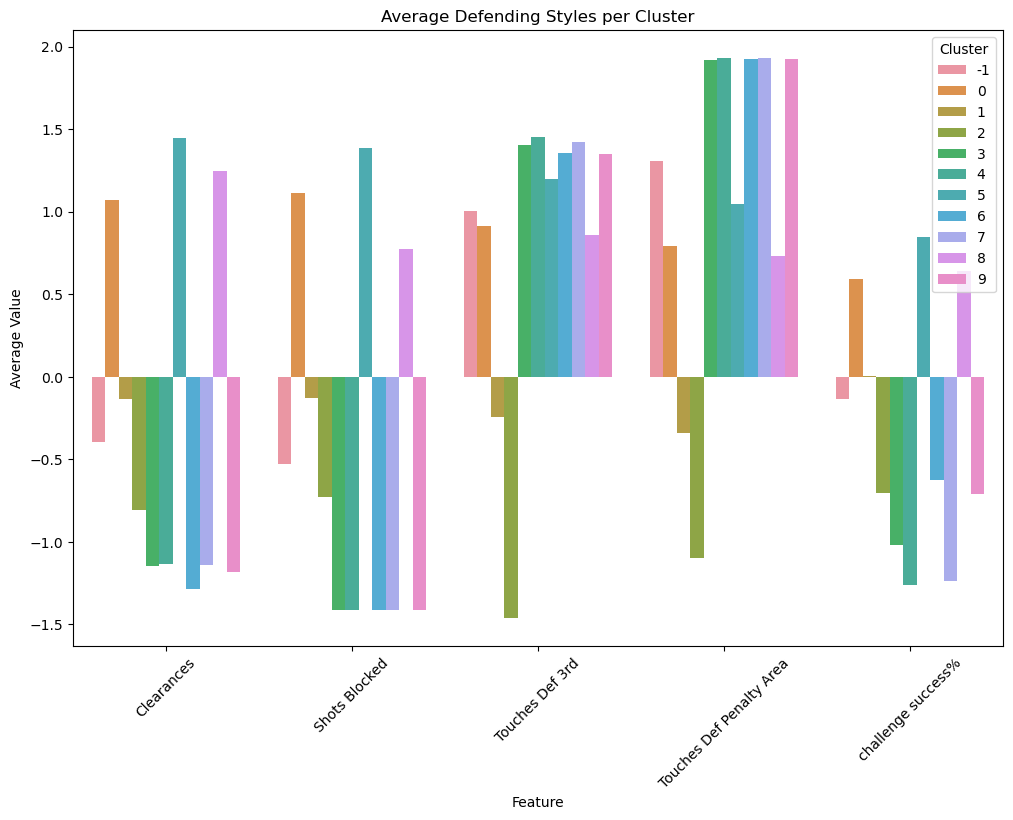

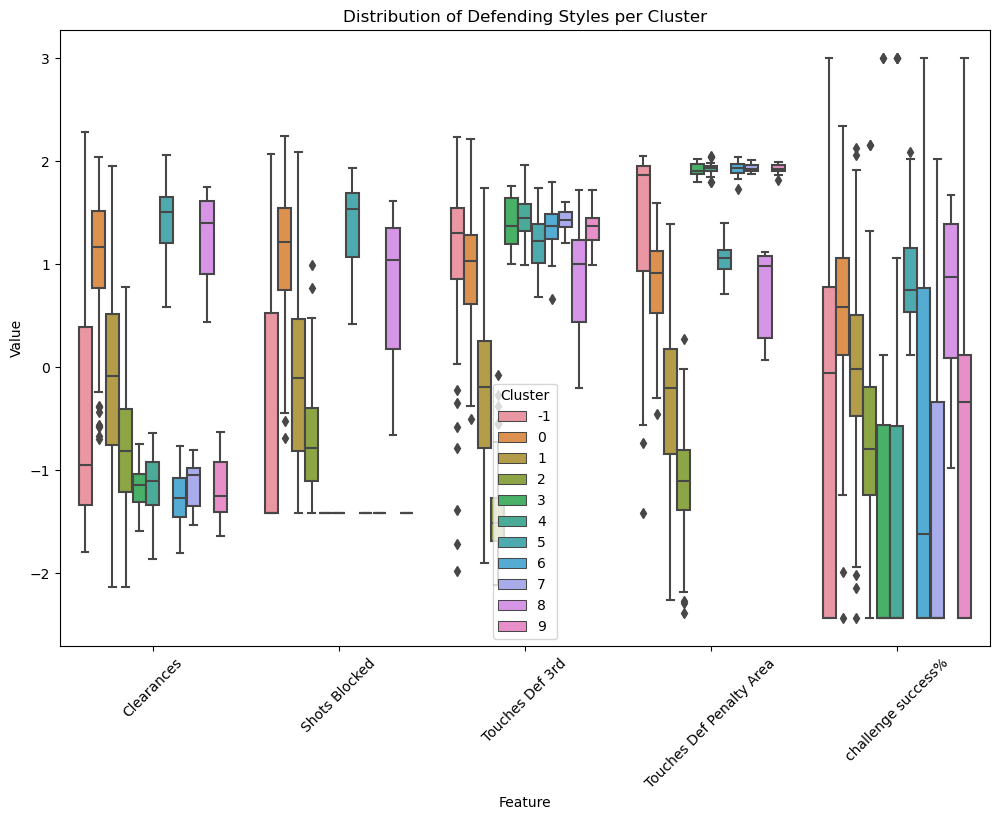

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you have a DataFrame 'df' with your data and 'Cluster' as the cluster label
# Create a list of features for passing patterns and defending styles
passing_features = ['Short Completed%', 'Medium Completed%', 'Long Attempted Passes', 'Long Completed Passes', 'Total PrgPassDist']
defending_features = ['Clearances', 'Shots Blocked', 'Touches Def 3rd', 'Touches Def Penalty Area', 'challenge success%']

# Create a function to plot bar charts for average feature values per cluster
def plot_avg_feature_per_cluster(df, features, title):
    cluster_means = df.groupby('Cluster')[features].mean().reset_index()
    melted_cluster_means = pd.melt(cluster_means, id_vars='Cluster', var_name='Feature', value_name='Average Value')
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=melted_cluster_means, x='Feature', y='Average Value', hue='Cluster')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

# Create a function to plot box plots for feature distributions per cluster
def plot_feature_distribution_per_cluster(df, features, title):
    melted_df = pd.melt(df, id_vars='Cluster', value_vars=features, var_name='Feature', value_name='Value')
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=melted_df, x='Feature', y='Value', hue='Cluster')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(title='Cluster')
    plt.show()

# Plotting the passing patterns
plot_avg_feature_per_cluster(df, passing_features, 'Average Passing Patterns per Cluster')
plot_feature_distribution_per_cluster(df, passing_features, 'Distribution of Passing Patterns per Cluster')

# Plotting the defending styles
plot_avg_feature_per_cluster(df, defending_features, 'Average Defending Styles per Cluster')
plot_feature_distribution_per_cluster(df, defending_features, 'Distribution of Defending Styles per Cluster')